In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from network import CNN
from load_data import ToTensor, ADdataset
from extractor import feature_extractor

In [2]:
#load a trained cnn model
network = CNN(3, 2, 8, 9)
network.load_state_dict(torch.load('/Users/ophelia/Desktop/Brain2+5SamplesCV/checkpoint_20.pth'))
network.eval()
network.zero_grad()

In [3]:
# load image dataset
path = "/Users/ophelia/Desktop/BrainSamples"
cv = "/Users/ophelia/Desktop/Brain2+5SamplesCV/cv10_1002_Test2.npy"

AD_DataSet=ADdataset(path=path,cv=cv,transform=ToTensor())
AD_DataLoader=DataLoader(AD_DataSet, batch_size=1,shuffle=False)

In [4]:
#sample image and labels
a = 0
for i in AD_DataLoader:
    I = i['image']
    c = i['label']
    a += 1
    if a == 90:
        break

In [5]:
#extract gradient and activation maps for both classes at intermediate layer
extractor = feature_extractor(network, network.dcc1[1])
activation0, gradient0 = extractor.get_features(I, index=0)
activation1, gradient1 = extractor.get_features(I, index=1)

original tensor([[[[171., 167., 196.,  ..., 183., 184., 181.],
          [177., 175., 203.,  ..., 172., 176., 176.],
          [198., 194., 191.,  ..., 192., 192., 192.],
          ...,
          [185., 183., 202.,  ..., 190., 197., 187.],
          [193., 189., 131.,  ..., 186., 193., 186.],
          [195., 194., 137.,  ..., 187., 193., 186.]],

         [[171., 170., 185.,  ..., 151., 153., 151.],
          [172., 172., 176.,  ..., 166., 161., 162.],
          [167., 175., 183.,  ..., 173., 169., 168.],
          ...,
          [180., 183., 171.,  ..., 176., 180., 199.],
          [172., 173., 170.,  ..., 181., 185., 197.],
          [170., 172., 164.,  ..., 177., 179., 192.]],

         [[147., 181., 178.,  ..., 122., 120., 118.],
          [124., 143., 141.,  ..., 137., 140., 123.],
          [126., 142., 139.,  ..., 132., 136., 119.],
          ...,
          [144., 166., 172.,  ..., 158., 157., 187.],
          [149., 169., 172.,  ..., 157., 156., 191.],
          [144., 150., 1

/Users/ophelia/Desktop/research/gradcam-seg/extractor.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = m(self.model(I))


In [6]:
print(I.shape)
print(activation0.shape)

torch.Size([1, 3, 132, 132])
torch.Size([1, 16, 62, 62])


Text(0.5, 1.0, 'Class 1 (Tau)')

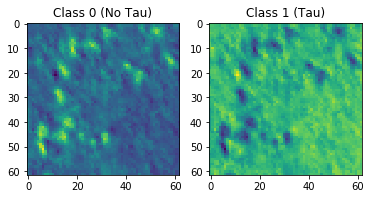

In [7]:
# plot grad-cam for both classes

#class 0 (No Tau)
cam_0 = torch.sum(activation0 * torch.mean(gradient0[0],dim=(-1,-2),keepdim=True),dim=(0,1))
fig,ax = plt.subplots(1, 2)
ax[0].imshow(cam_0)
ax[0].set_title('Class 0 (No Tau)')

#class 1 (Tau)
cam_1 = torch.sum(activation1 * torch.mean(gradient1[0],dim=(-1,-2),keepdim=True),dim=(0,1))
ax[1].imshow(cam_1)
ax[1].set_title('Class 1 (Tau)')


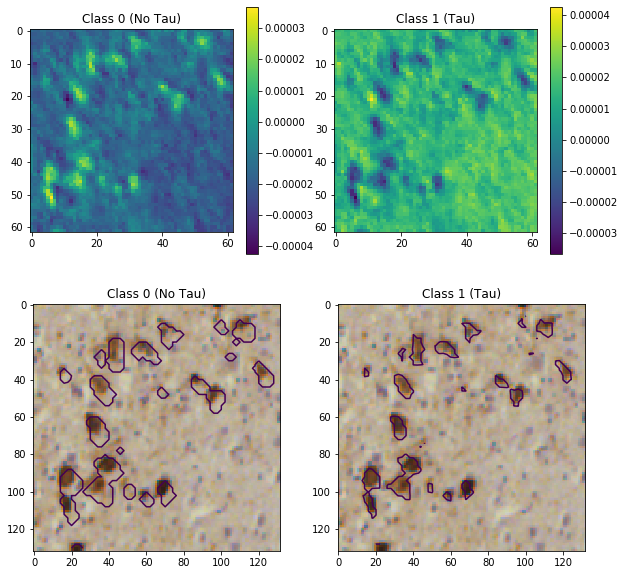

In [11]:
#contour segmentations over original image
fig1, ax1 = plt.subplots(2, 2, figsize=(10, 10))

#plot CAMs with colorbar
h = ax1[0][0].imshow(cam_0)
plt.colorbar(h, ax=ax1[0][0])
ax1[0][0].set_title('Class 0 (No Tau)')
h1 = ax1[0][1].imshow(cam_1)
plt.colorbar(h1, ax=ax1[0][1])
ax1[0][1].set_title('Class 1 (Tau)')

ax1[1][0].imshow(I[0,:3,:,:].permute(1,2,0)/255)
ax1[1][1].imshow(I[0,:3,:,:].permute(1,2,0)/255)

#using gradients for class 0
alpha = torch.mean(gradient0[0],(-1,-2))
gradcam0 = torch.as_tensor(torch.relu(torch.mean(activation0*alpha[...,None,None],1)))
gradcam0 = torch.as_tensor(gradcam0.detach().numpy())

x0 = torch.arange(gradcam0[0].shape[0])*2+8
x1 = torch.arange(gradcam0[0].shape[1])*2+8
ax1[1][0].contour(x0,x1,gradcam0[0],[torch.max(gradcam0[0])*0.0005])

#using gradients for class 1
alpha = torch.mean(gradient1[0],(-1,-2))
gradcam1 = torch.as_tensor(torch.relu(torch.mean(activation1*alpha[...,None,None],1)))
gradcam1 = torch.as_tensor(gradcam1.detach().numpy())

x00 = torch.arange(-1, gradcam1[0].shape[0]-1)*2+8
x11 = torch.arange(-1, gradcam1[0].shape[1]-1)*2+8

ax1[1][1].contour(x00,x11,gradcam1[0],[torch.max(gradcam1[0])*0.01])

ax1[1][0].title.set_text("Class 0 (No Tau)")
ax1[1][1].title.set_text("Class 1 (Tau)")

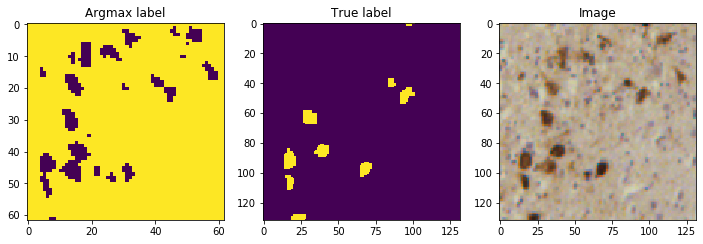

In [9]:
#argmax to produce binary labels 
m = torch.stack((cam_0, cam_1))
m = torch.argmax(m, dim=0)

f, a = plt.subplots(1, 3, figsize=(12, 5))
a[0].imshow(m)
a[0].title.set_text("Argmax label")
a[1].imshow(c[0])
a[1].title.set_text("True label")
a[2].imshow(I[0,:3,:,:].permute(1,2,0)/255)
a[2].title.set_text("Image")